In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models import BFDataset, VAE, BFVAE
from MMD_func import MMD_U as MMD
rng = np.random.default_rng()

In [3]:
# import training and test data
path = 'Data/beam_data.npz'
file = np.load(path)
idx = np.linspace(0, 512, 128).astype('int')
xL_trn = torch.from_numpy(file['beam_yL'][:4000,idx]).type(torch.FloatTensor)
xL = torch.from_numpy(file['beam_yL'][:9000,idx]).type(torch.FloatTensor)
xH = torch.from_numpy(file['beam_yH'][:9000,idx]).type(torch.FloatTensor)
xH_tst = torch.from_numpy(file['beam_yH'][9000: 10000,idx]).type(torch.FloatTensor)

In [4]:
## Universal hyper-para
_,input_dim = xH_tst.shape
batch_size = 64
tst_size = 1000
mmd_para = [0.2, 0.5, 1.0, 2.0, 5.0]
latent_dim = 4
hidden_dims = [64, 16]
beta = 1.25
num_trial = 10
hf_size_lst = [2, 5, 7, 10, 50, 100, 500, 1000, 5000]


# claim and train lf-vae
lfvae_model = VAE(input_dim, latent_dim, hidden_dims, beta)
lfvae_loss = lfvae_model.train(xL_trn, epochs=2000)

100%|██████████| 2000/2000 [04:46<00:00,  6.98 Epoch/s, loss=83.83811] 


In [5]:
hf_mmd_lst, bf_mmd_lst = [], []
hfvae_lst, bfvae_lst = [], []
for hf_size in hf_size_lst:
    hf_mmd, bf_mmd = [], []
    hfvae, bfvae = [], []
    for _ in range(num_trial):      
        # claim and train hf-vae
        hf_trn_idx = rng.choice(8000, hf_size, replace=False)
        hf_trn_data = xH[hf_trn_idx]
        hfvae_model = VAE(input_dim, latent_dim, hidden_dims, beta)
        hfvae.append(hfvae_model)
        hfvae_loss = hfvae_model.train(hf_trn_data, epochs=1000)

        # claim and train bf-vae
        hf_trn_data = xH[hf_trn_idx]
        lf_trn_data = xL[hf_trn_idx]
        bf_trn_data = BFDataset(lf_trn_data, hf_trn_data)
        bfvae_model = BFVAE(lfvae_model)
        bfvae.append(bfvae_model)
        bfvae_loss = bfvae_model.train(bf_trn_data, epochs=1000)

        ## Compute MMD result
        # HF-VAE
        hf_gen = hfvae_model.sample(1000)
        hf_mmd.append(MMD(hf_gen, xH_tst, mmd_para)) 

        # BF-VAE
        bf_gen = bfvae_model.sample(1000)
        bf_mmd.append(MMD(bf_gen, xH_tst, mmd_para)) 
        
    hf_mmd_lst.append(hf_mmd)
    bf_mmd_lst.append(bf_mmd)
    hfvae_lst.append(hfvae)
    bfvae_lst.append(bfvae)

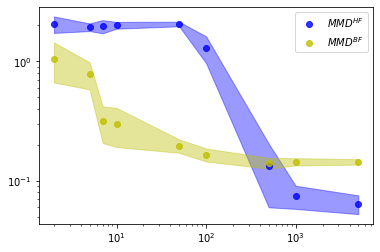

In [6]:
scale = 0.5
hf_mean, bf_mean = np.mean(hf_mmd_lst, axis=1), np.mean(bf_mmd_lst, axis=1)
hf_std, bf_std = np.std(hf_mmd_lst, axis=1), np.std(bf_mmd_lst, axis=1)
plt.plot(hf_size_lst, hf_mean, 'o' ,c='b', label=r'$MMD^{HF}$', alpha=0.8)
plt.fill_between(hf_size_lst, hf_mean - scale * hf_std, hf_mean + scale * hf_std, color='b', alpha=0.4)
plt.plot(hf_size_lst, bf_mean, 'o' ,c='y', label=r'$MMD^{BF}$', alpha=0.8)
plt.fill_between(hf_size_lst, bf_mean - scale * bf_std, bf_mean + scale * bf_std, color='y', alpha=0.4)
plt.legend()
plt.xscale('log')
plt.yscale('log')

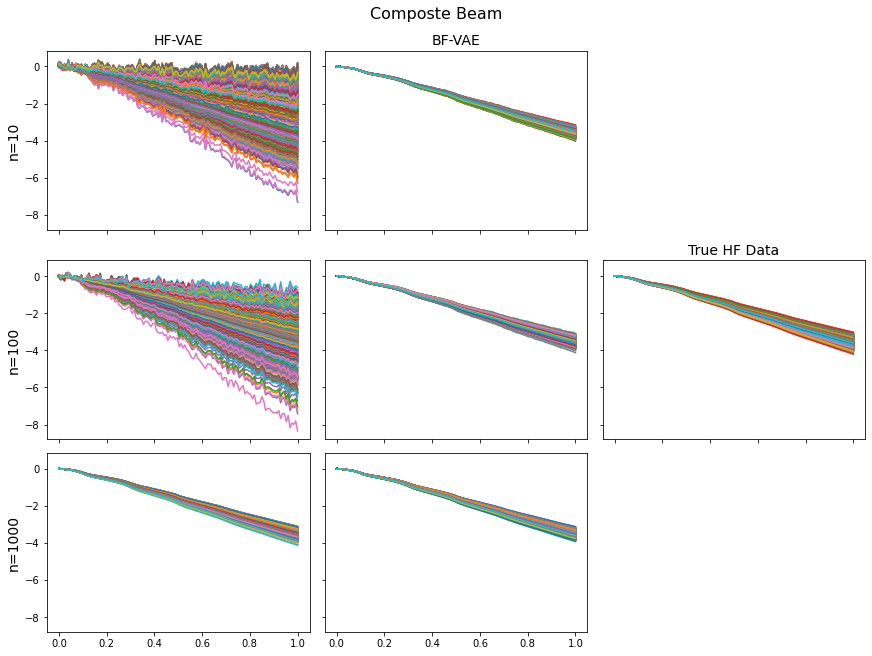

In [14]:
plt.rcParams['figure.constrained_layout.use'] = True
fig, axs = plt.subplots(3,3,figsize=(12,9),sharey=True,sharex=True)
fig.suptitle('Composte Beam', fontsize=16)
t = np.linspace(0,1,128)
hf_N = [3, 5, 7]

bf_gen_lst, hf_gen_lst = [], []

for i in range(1000):
    axs[1,2].plot(t, xH_tst[i].detach().numpy())

axs[0,2].axis('off')
axs[2,2].axis('off')
axs[0,0].set_title(r'HF-VAE',fontsize=14)
axs[0,1].set_title(r'BF-VAE',fontsize=14)
axs[1,2].set_title(r'True HF Data',fontsize=14)

for j in range(len(hf_N)):
    N = hf_N[j]
    axs[j,0].set_ylabel(r'n='+str(hf_size_lst[N]),fontsize=14)
    bf_gen = bfvae_lst[N][0].sample(1000).detach().numpy()
    hf_gen = hfvae_lst[N][0].sample(1000).detach().numpy()
    bf_gen_lst.append(bf_gen)
    hf_gen_lst.append(hf_gen)
    for i in range(1000):
        axs[j,0].plot(t, hf_gen[i])
        axs[j,1].plot(t, bf_gen[i])